In [ ]:
from pandas_datareader import data as pdr
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes='Ture')

In [2]:
df=pdr.get_data_yahoo('BTC-USD',start='2008-03-28',end='2021-11-16')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014
...,...,...,...,...,...,...
2021-11-12,65460.816406,62333.914062,64863.980469,64155.941406,3.608489e+10,64155.941406
2021-11-13,64915.675781,63303.734375,64158.121094,64469.527344,3.047423e+10,64469.527344
2021-11-14,65495.179688,63647.808594,64455.371094,65466.839844,2.512209e+10,65466.839844


<AxesSubplot:>

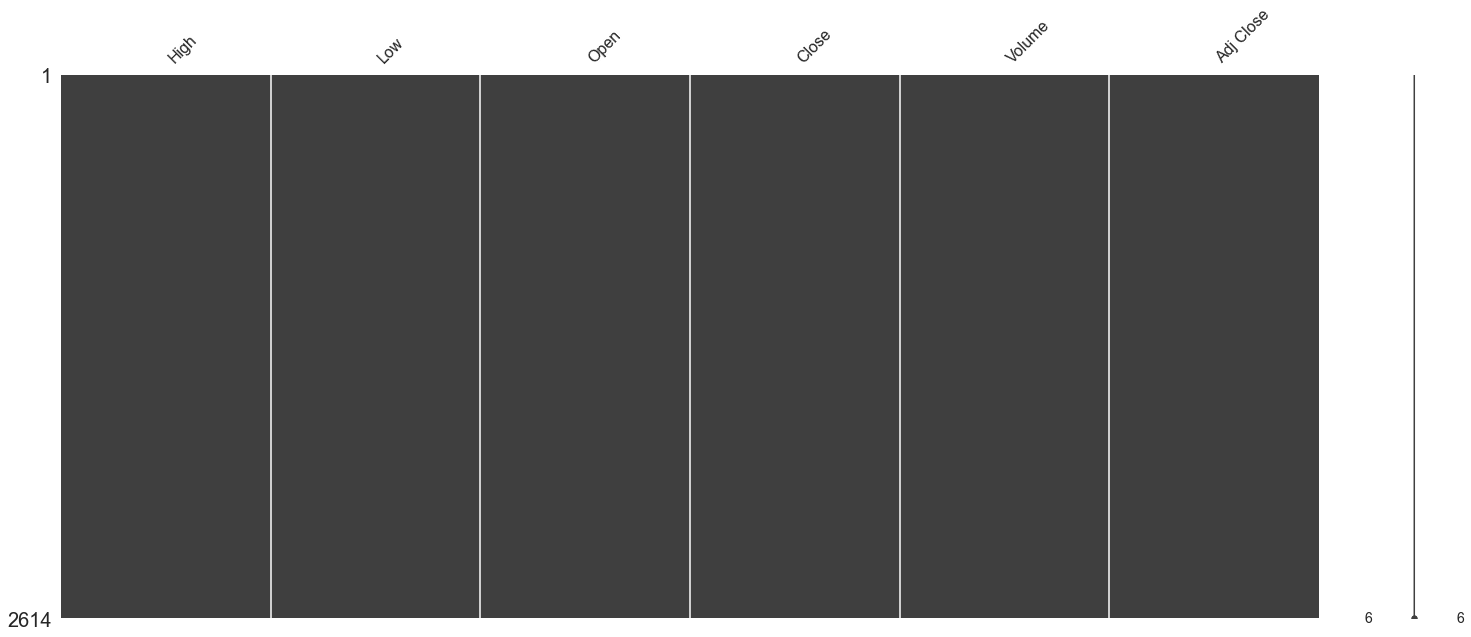

In [3]:
#可视化缺失值
msno.matrix(df)

In [4]:
# 将dataframe按索引降序排列
data = df.sort_index(ascending=True, axis=0)
#只用Close这一列，即只使用股票的收盘价来进行拟合和预测
dataset=data[['Close']].values

#取80%的数据作为训练集
training_data_len=math.ceil(len(dataset)*.8)
train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60天的数据来预测，因此这倒溯了60天
test_data = dataset[training_data_len-60: , : ]

In [5]:
#特征缩放
scaler=MinMaxScaler(feature_range=(0,1))
scaled_train=scaler.fit_transform(train_data)
scaled_test=scaler.fit_transform(test_data)

In [6]:
#训练集的重构
#1 分离x和y
x_train=[]
y_train=[]
for i in range(60,len(scaled_train)):
    x_train.append(scaled_train[i-60:i,0])
    y_train.append(scaled_train[i,0])
#2 将list类型数据转变成array数据
x_train,y_train=np.array(x_train),np.array(y_train)

#3 将二维数据变成三维数据
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [7]:
#测试集的重构
#1 分离x和y
x_test = []
y_test = dataset[training_data_len: , : ] 
for i in range(60,len(scaled_test)):
    x_test.append(scaled_test[i-60:i,0])
#2 将list类型数据转变成array数据
x_test = np.array(x_test)
#3 将二维数据变成三维数据
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [8]:
#构建模型
#初始化模型
model = Sequential()
#LSTM层
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
#Dropout层
model.add(Dropout(.2))
#LSTM层
model.add(LSTM(units=50, return_sequences=False))
#Dropout层
model.add(Dropout(.2))
#全连接层
model.add(Dense(units=1))
#模型编译
model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M1


2021-11-16 20:26:44.775717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-16 20:26:44.775802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

In [ ]:
#模型结构
model.summary()

In [ ]:
#拟合模型
model.fit(x_train, y_train, batch_size=25, epochs=1000)

In [ ]:
#预测
predictions = model.predict(x_test) 
#还原 特征缩放
predictions = scaler.inverse_transform(predictions)

In [ ]:
#创建用来画图的dataframe
train = data[:training_data_len]
valid = data[training_data_len:]
#给valid添加新的一列，把预测值predictions赋值给新的一列
valid['Predictions'] = predictions
#开始作图
#图像大小
plt.figure(figsize=(16,8))
#x轴
plt.xlabel('Date', fontsize=18)
#y轴
plt.ylabel('Close Price USD ($)', fontsize=18)
#画训练集的折线图
plt.plot(train['Close'])
#分别画出真实值和预测值的折线图
plt.plot(valid[['Close', 'Predictions']])
#展示图例
plt.legend(['Train', 'Val', 'Predictions'],fontsize=15)
plt.show()